# 영화 리뷰 감성분석 경진대회

## 패키지 import및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

In [2]:
data = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/영화-리뷰-감성분석/Data/train.csv')

In [3]:
data.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


`-` 긍정 리뷰는 label이 1, 부정 리뷰는 label이 0으로 되어있다

In [4]:
data.shape ## 총 5000개의 영화 리뷰 정보

(5000, 3)

In [5]:
data.isnull().values.any() ## 결측치는 존재하지 않는다

False

## 데이터 EDA

### 긍정/부정 count 시각화

`-` 라벨의 분포 확인

In [6]:
plt.style.use('ggplot')

In [7]:
feature = data['label']

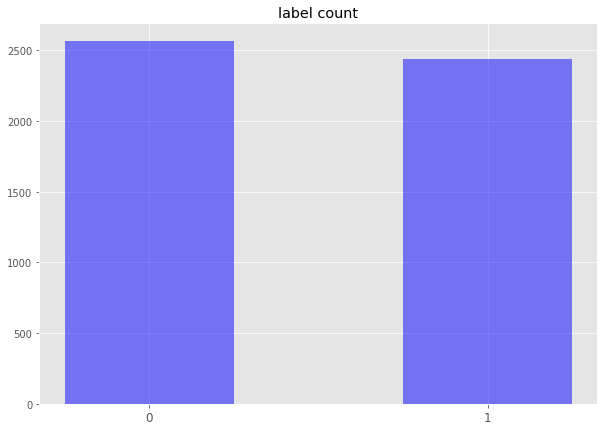

In [8]:
plt.figure(figsize = (10, 7))
plt.title('label count')
plt.bar(feature.value_counts().keys(), feature.value_counts().values, width = 0.5, color = 'blue', alpha = 0.5) 
plt.xticks(feature.value_counts().keys(), fontsize = 12)
plt.show()

### 리뷰 길이 확인

In [9]:
str_len_mean = np.mean(data['document'].str.len())
print('리뷰의 평균 길이 :', str_len_mean)

리뷰의 평균 길이 : 27.1352


`-` 리뷰의 평균 길이는 약 27이다

In [10]:
print('리뷰의 최소 길이 :', np.min(data['document'].str.len()))

리뷰의 최소 길이 : 16


`-` 리뷰의 최소 길이는 16이다

In [11]:
print('리뷰의 최대 길이 :', np.max(data['document'].str.len()))

리뷰의 최대 길이 : 42


`-` 리뷰의 최대 길이는 42이다

### 전체리뷰 / 긍정리뷰 / 부정리뷰 비교

In [12]:
## 긍정/부정 라벨의 인덱스 번호
pos_label = (data.label == 1)
neg_label = (data.label == 0)

# 전체 / 긍정 / 부정 리뷰 집합을 설정
df_train = data.document.copy() ## 전체 train 데이터
df_pos = data.loc[pos_label,:].document ## 긍정 리뷰에만 해당하는 train 데이터
df_neg = data.loc[neg_label,:].document ## 부정 리뷰에만 해당하는 train 데이터

# 세 집합을 리스트로 묶어줌
compare = [df_train, df_pos, df_neg]

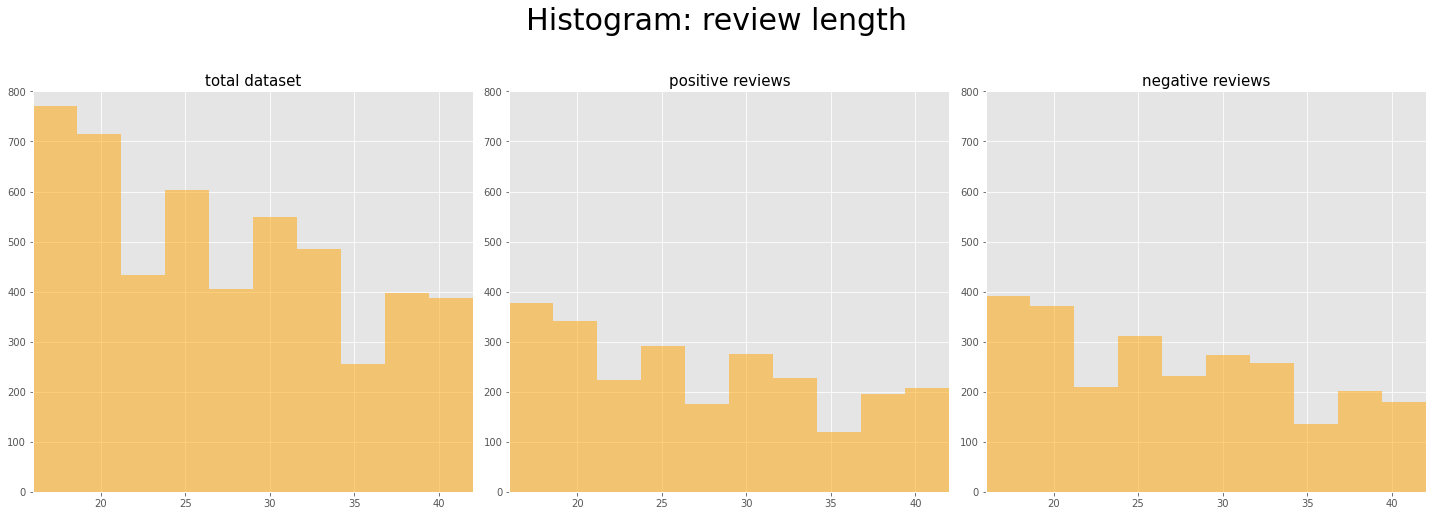

In [13]:
# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize = (20, 7.5))
plt.suptitle('Histogram: review length', fontsize = 30)
name = ['total dataset', 'positive reviews', 'negative reviews']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]    
    plt.subplot(1, 3, i+1) ## 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize = 15)
    plt.axis([16, 42, 0, 800])  
    plt.hist(string_len, alpha = 0.5, color = 'orange')

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

`-` 긍정/부정 리뷰 상관없이 리뷰의 길이는 비슷한 분포를 가진다

`-` 이번에는 리뷰의 길이가 아닌 어절의 개수를 가지고 시각화하자

In [14]:
word_split = data['document'].str.split() ## 공백을 기준으로 문자열을 분리
word_split[:5]

0                     [영상이나, 음악이, 이쁘다, 해도, 미화시킨, 불륜일뿐]
1                 [히치콕이, 이, 영화를, 봤다면, 분명, 박수를, 쳤을듯...]
2       [괜찮은, 음악영화가, 또, 나왔군요!!!, 따뜻한, 겨울이, 될, 것, 같아요~]
3                      [아무래도, 20년도지난작품이라, 지금보기는너무유치하다]
4    [지금까지의, 영화들이, 그랬듯., 이, 영화역시, 일본에, 대한, 미화는, 여전하다.]
Name: document, dtype: object

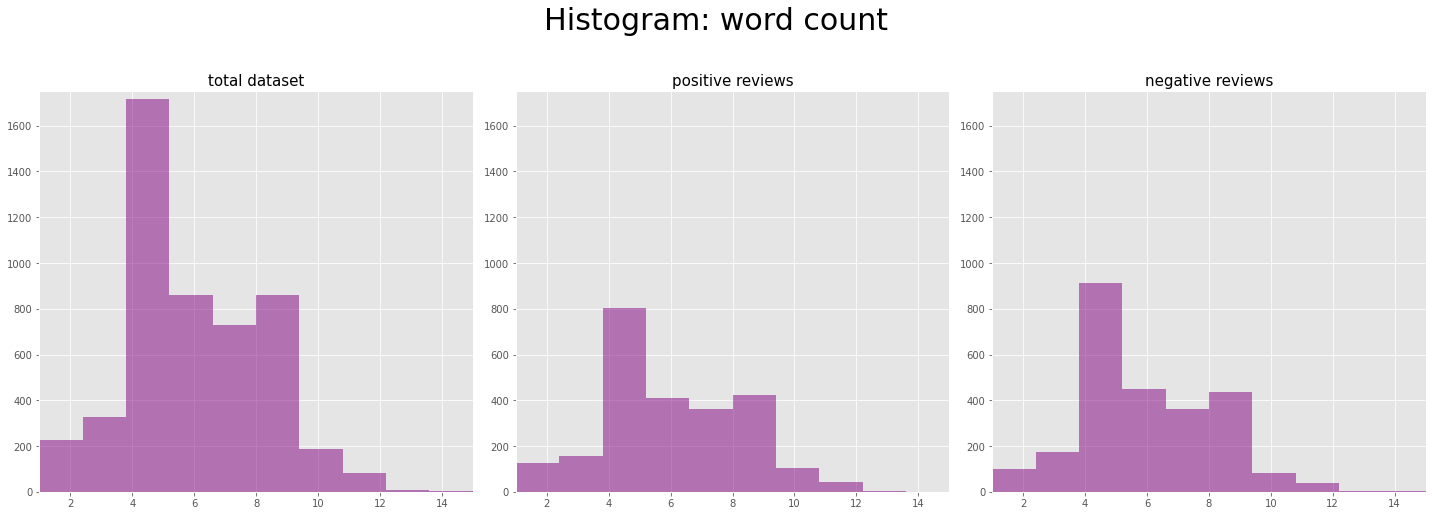

In [15]:
plt.figure(figsize = (20, 7.5))
plt.suptitle('Histogram: word count', fontsize = 30)
name = ['total dataset', 'positive reviews', 'negative reviews']

for i in range(len(compare)):
    document = compare[i]
    split = document.str.split()
    split_len = [len(x) for x in split] 
    plt.subplot(1, 3, i+1) ## 행 개수/ 열 개수/ 해당 그래프 표시 순서
    plt.title(name[i], fontsize = 15)
    plt.axis([1, 15, 0, 1750])  
    plt.hist(split_len, alpha = 0.5, color = 'purple')
    
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

`-` 4~6개의 어절로 이루어진 리뷰가 가장 많다

`-` 긍정/부정 리뷰 상관없이 어절 개수의 분포는 비슷해 보인다

## Word Cloud

`-` 워드 클라우드(word cloud) : 메타 데이터에서 얻어진 태그들을 분석하여 중요도 등을 고려하여 시각적으로 표현한 것

`-` 참고 : https://ko.wikipedia.org/wiki/%ED%83%9C%EA%B7%B8_%ED%81%B4%EB%9D%BC%EC%9A%B0%EB%93%9C

In [16]:
def df_to_str(df):
    ##전체 리뷰들을 하나의 문자열로 만드는 과정
    
    s = [s for s in df] ## df를 리스트로 만듦
    document = "" ## 빈 문자열
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    ## okt tagger를 이용해 명사를 추출하는 과정
    okt = Okt() ## Okt 클래스의 인스턴스 생성
    noun = okt.nouns(text) ## nouns 메소드를 사용해 text에서 명사를 추출한다 
    for idx, string in enumerate(noun):
        if len(string) < 2: ## 길이가 2보다 작은 문자는 제거한다
            noun.pop(idx)
    count = Counter(noun) ## 단어의 등장 횟수를 딕셔너리로 만든다
    noun_list = count.most_common(100) ## 가장 많이 등장한 상위 100개의 명사만 선택하여 리스트로 만듦

    return noun_list

def visualize(noun_list, title):
    ## 워드클라우드 이미지 생성
    wc = WordCloud(                    ## WordCloud 클래스의 인스턴스 생성
         font_path = 'gulim',          ## 한글폰트 경로 설정 ## C:/Windows/Fonts에 있는 폰트 중 하나를 우클릭, 속성(R) 클릭 후 나와있는 이름을 그대로 적음
         background_color = 'white',   ## 배경 색깔 정하기
         colormap = 'Dark2',           ## 폰트 색깔 정하기
         width = 800,
         height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize = (10, 10))  ## 이미지 사이즈 지정
    plt.suptitle('Word Cloud', fontsize = 40)
    plt.title(title, fontsize = 20)
    plt.imshow(wc, interpolation = 'lanczos')  ## 이미지의 부드럽기 정도
    plt.axis('off')   ## x, y 축 숫자 제거
    plt.show()   ## 워드클라우드 이미지 확인
    
    return wc

`-` 전체 train 데이터 워드 클라우드 생성

In [17]:
document = df_to_str(df_train)
noun_list = get_noun(document)
noun_list[:5] ## 상위 5개 단어 확인

[('영화', 1501), ('정말', 320), ('진짜', 269), ('최고', 220), ('평점', 185)]

In [18]:
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  ## 한글 폰트 사용시 마이너스 폰트 깨짐 해결

`-` 참고 : https://wikidocs.net/45798

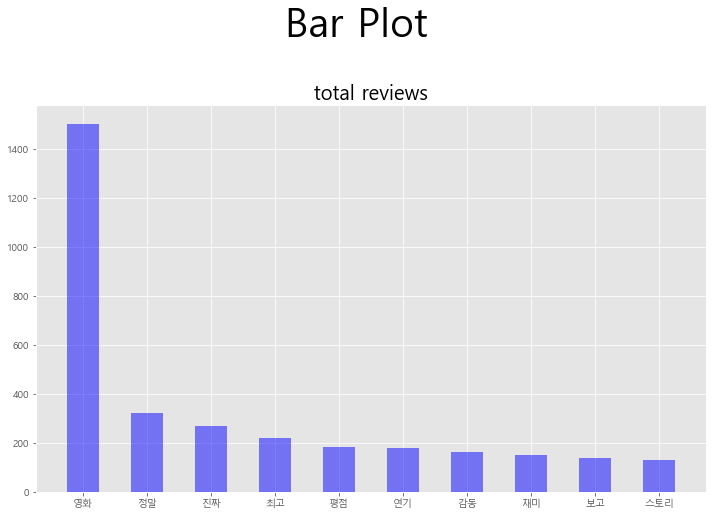

In [19]:
# plt.rc('font', family = 'NanumBarunGothic') 
top_10 = dict(noun_list[:10])
plt.figure(figsize = (10, 7.5))
plt.suptitle("Bar Plot", fontsize = 40)
plt.title('total reviews', fontsize = 20)
plt.bar(top_10.keys(), top_10.values(), width = 0.5, color = 'b', alpha = 0.5)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

`-` 영화 키워드가 가장 많이 등장한다(당연함)

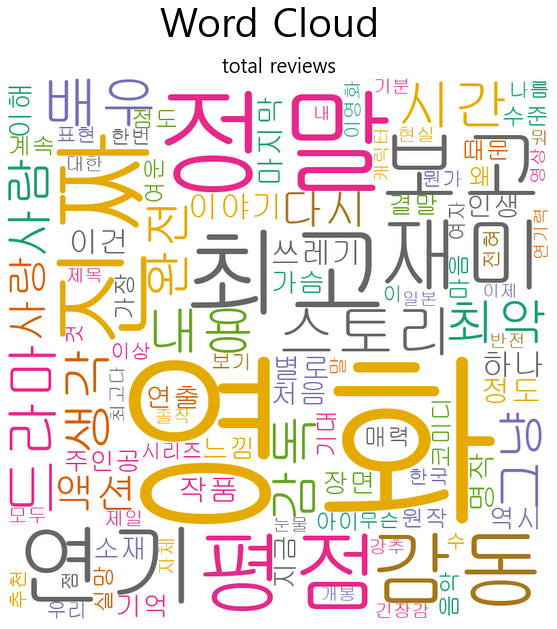

In [46]:
total_reviews = visualize(noun_list, 'total reviews')

`-` 긍정/부정 단어가 혼합되어 있다

### 긍정 리뷰 워드클라우드 생성

`-` 긍정 리뷰 워드 클라우드 생성

In [20]:
pos_document = df_to_str(df_pos)
pos_noun_list = get_noun(pos_document)
pos_noun_list[:5] ## 상위 5개 단어 확인

[('영화', 757), ('정말', 216), ('최고', 214), ('진짜', 136), ('감동', 134)]

`-` 최고, 감동같은 긍정적인 명사와 긍정/부정 상관없는 명사가 존재한다

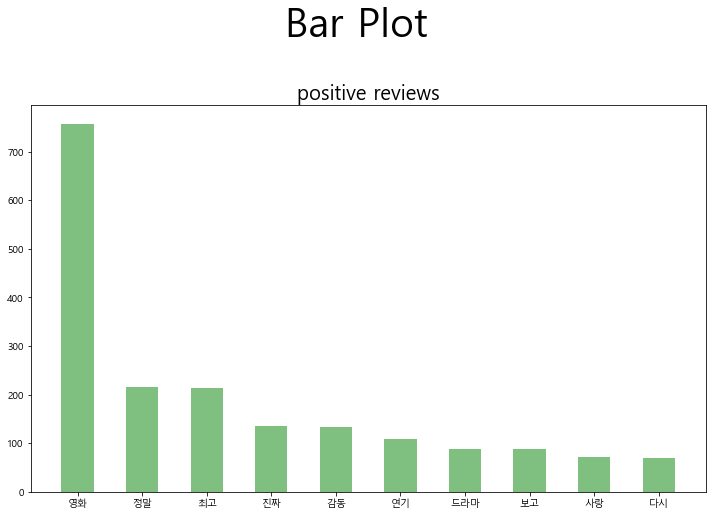

In [38]:
# plt.rc('font', family = 'NanumBarunGothic') 
top_10 = dict(pos_noun_list[:10])
plt.figure(figsize = (10, 7.5))
plt.suptitle("Bar Plot", fontsize = 40)
plt.title('positive reviews', fontsize = 20)
plt.bar(top_10.keys(), top_10.values(), width = 0.5, color = 'g', alpha = 0.5)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

`-` 영화 키워드가 가장 많이 등장한다(당연함)

`-` 최고, 감동, 사랑, 다시, 보고와 같은 명사가 많이 등장한다

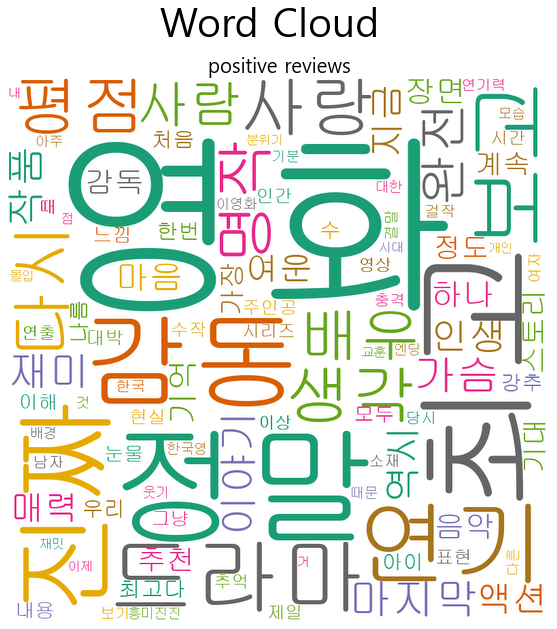

In [45]:
positive_reviews = visualize(pos_noun_list, 'positive reviews')

`-` 긍정 단어와 긍정/부정 상관없는 단어(ex 영화; 최고 영화, 최악 영화)가 보인다

### 부정 리뷰 워드클라우드 생성

`-` 부정 리뷰 워드 클라우드 생성

In [22]:
neg_document = df_to_str(df_neg)
neg_noun_list = get_noun(neg_document)
neg_noun_list[:5] ## 상위 5개 단어 확인

[('영화', 746), ('진짜', 132), ('평점', 118), ('재미', 104), ('정말', 104)]

`-` 긍정 리뷰와는 다르게 상위 5개 단어에 부정적인 뜻을 가진 명사가 존재하지 않은다

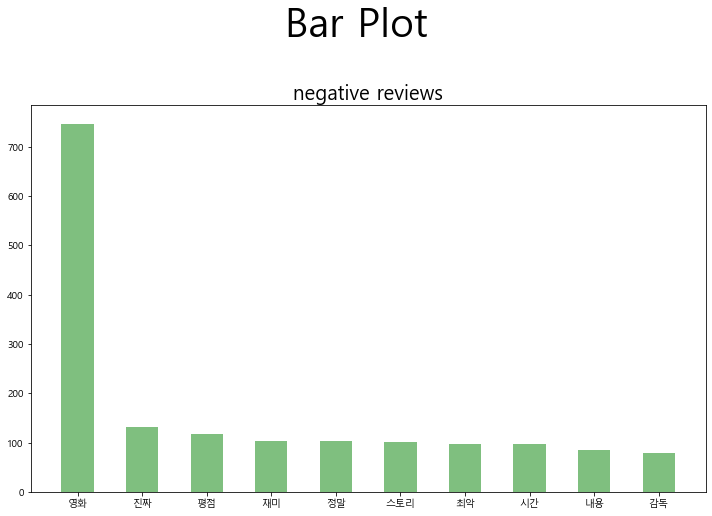

In [42]:
# plt.rc('font', family = 'NanumBarunGothic') 
top_10 = dict(neg_noun_list[:10])
plt.figure(figsize = (10, 7.5))
plt.suptitle("Bar Plot", fontsize = 40)
plt.title('negative reviews', fontsize = 20)
plt.bar(top_10.keys(), top_10.values(), width = 0.5, color = 'g', alpha = 0.5)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

`-` 영화 키워드가 가장 많이 등장한다(당연함)

`-` 가장 많이 등장한 상위 10개 명사 중에서 부정적인 단어는 최악 뿐이다

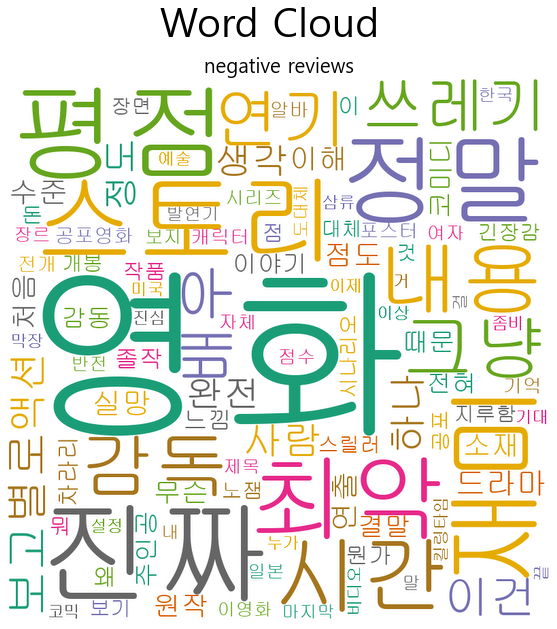

In [44]:
negative_reviews = visualize(neg_noun_list, 'negative reviews')

`-` 부정 단어와 긍정/부정 상관없는 단어가 보인다

## 워드 클라우드에서 중복 단어 제거하기

`-` 위 워드클라우드를 보면 긍정 부정 리뷰 모두 등장하는 단어들이 존재한다

`-` 이를 해결하기 위해 긍정/부정 리뷰에 공통적으로 등장하는 단어들을 제거한 뒤 다시 시각화하자

In [23]:
neg = list(dict(neg_noun_list).keys())
pos = list(dict(pos_noun_list).keys())
drop_words = [x for x in neg if x in pos] 
print('공통으로 등장하는 단어들 Top10\n', drop_words[:10])

공통으로 등장하는 단어들 Top10
 ['영화', '진짜', '평점', '재미', '정말', '스토리', '시간', '내용', '감독', '그냥']


`-` 해당 단어들을 각각 단어 리스트에서 제거

In [49]:
pos_noun_list_filter = [x for x in pos_noun_list if x[0] not in drop_words]
neg_noun_list_filter = [x for x in neg_noun_list if x[0] not in drop_words]

`-` 정제된 두 단어 리스트들을 워드클라우드로 시각화

`-` 긍정 리뷰

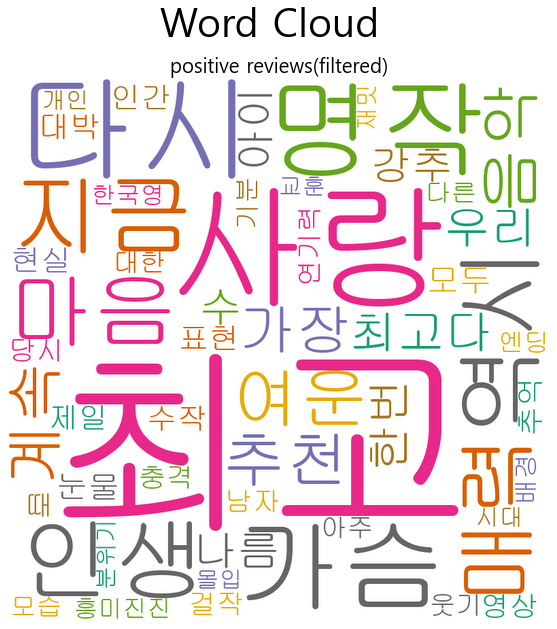

In [52]:
positive_reviews_filtered = visualize(pos_noun_list_filter, 'positive reviews(filtered)')

`-` 최고, 사랑, 다시, 명장과 같은 단어가 보인다

`-` 부정 리뷰

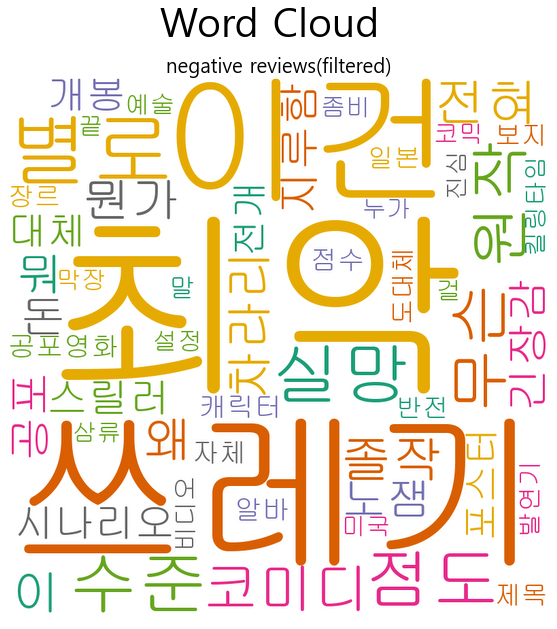

In [53]:
negative_reviews_filtered = visualize(neg_noun_list_filter, 'negative reviews(filtered)')

`-` 최악, 쓰레기, 이건, 별로 같은 단어가 보인다